# Assignment 2. MLP MNIST classification - Finetuning

이번 과제는 4주차와 5주차에 배운 내용을 이용해 MLP를 구성하고 학습을 진행해 봅니다.

2가지 종류의 MNIST 데이터에 대해 다양한 모델 구조를 적용해 학습을 진행해 보고 여러 기법들에 따라 어떻게 학습 양상이 달라지는 지 분석해 봅니다.

여러 모델 구조와 기법들 중에서 최적의 조건을 찾아 성능을 향상 시키는 것이 과제의 목표입니다.

AI 엔지니어로서 여러분은 데이터의 특징을 분석해서 적절한 모델 구조와 다양한 hyper parameter를 결정해야 합니다. 그렇지만 아무리 insight가 좋은 엔지니어라도 데이터만 봐서는 최적의 모델 세팅을 알아낼 수는 없을 겁니다. 다양한 모델을 구성하고 직접 학습을 진행해 봐야 하고 새로운 아이디어도 적용해 볼 수 있어야 합니다.

5주차 실습에서 사용한 trainer class를 여러분의 입맛에 맞게 변형하여 각자 적용해보고 싶은 기능들의 성능을 확인해 봅시다.

### 1. Data

이번 과제는 MNIST와 FMNIST 데이터를 사용합니다. 

그렇지만 다양한 종류의 데이터에 적용할 수 있는 범용적인 코드를 작성하여, 2개의 데이터 셋에 대해 코드의 큰 변형 없이 적용하는 것을 목표로 하겠습니다.

각 데이터 셋에 대해 다르게 나타날 최적의 hyperparameter setting을 찾아보도록 하겠습니다.

### 2. Model structure

기본적인 MLP 구조에서 여러분은 hidden layer를 몇 층 쌓을지, 각 layer의 width, activation function과 dropout, batch normalization의 적용 여부를 결정하셔야 합니다.

주어진 데이터에 대해 최대의 성능을 내는 어떤 설정이 존재하기는 하겠지만, 이걸 한 번에 찾는 건 어렵겠죠? 심지어 모델 초기화 등에 randomness가 존재하기 때문에 매번 미세하게 달라질 겁니다.

이러한 randomness까지는 고려하지 않더라도 모델 구조와 다른 세팅을 바꿔가며 각 데이터셋에 대해 학습을 진행하여 test dataset에 대한 성능을 확인해 보도록 하겠습니다.

### 3. Optimization procedure

이미 실습에서 확인하셨겠지만 모델 구조 외에도 어떠한 optimizer와 learning rate을 사용하느냐도 성능에 굉장히 큰 영향을 줍니다.

많이 사용되는 SGD와 Adam optimizer 외에도 다른 알고리즘들을 적용해 보겠습니다.

optimizer의 종류 외에도 각 optimizer의 hyperparameter도 있지만, 이것까지는 tuning을 하지 않아도 될 것 같습니다. 이러한 hyperparameter들은 일반적으로 고정 시켜서 사용하는 추세입니다!

### 4. 평가

지금까지 언급한 경우만 고려하더라도 데이터 종류, 모델 종류, optimizer 종류, lr 까지 하여 tuning할 요소가 4가지나 됩니다.

4종류의 모델, 3종류의 optimizer와 lr을 3가지 확인한다고 하면 이미 72번의 실험을 진행해야겠네요.

때문에 이렇게 많은 실험들을 효율적으로 정리하고 실행하는 것도 굉장히 중요하답니다.

이번 과제에서는 for 문을 이용해 여러 번의 실험을 진행한 후 최적의 세팅을 찾아 학습을 한 번 더 진행하는 것으로 하겠습니다.

실제로는 다양한 hyperparameter에 대한 search를 자동으로 해주는 tool들이 개발되어 있으니 관심 있으신 분들은 찾아보셔도 좋을 것 같습니다. 이번 과제에서는 필요하지 않습니다!


### Mount Drive and Import Pacakges

In [62]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
import os

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from torchvision import datasets, transforms

import matplotlib.pyplot as plt
%matplotlib inline

## 1. Data

### Load and prepare data

In [64]:
root = os.path.join(os.getcwd(), "drive", "MyDrive", "Colab Notebooks", "data")
root

'/content/drive/MyDrive/Colab Notebooks/data'

In [65]:
def get_data(data, root, download=True, transform=transforms.ToTensor()):
  if data.lower() == "mnist":
    train = datasets.MNIST(root=root, train=True, download=download, transform=transform)
    test = datasets.MNIST(root=root, train=False, download=download, transform=transform)
  elif data.lower() == "fmnist":
    train = datasets.FashionMNIST(root=root, train=True, download=download, transform=transform)
    test = datasets.FashionMNIST(root=root, train=False, download=download, transform=transform)
  else:
    raise ValueError(f"data name {data} is not supported.")

  return train, test

In [66]:
mnist_tr, mnist_test = get_data(data="MNIST", root=root)
fmnist_tr, fmnist_test = get_data(data="FMNIST", root=root)

### Check datasets

In [67]:
def plot_mnist(data, figsize=(20, 10)):
  fig = plt.figure(figsize=figsize)
  for i in range(18):
    img = data[i][0]
    ax = fig.add_subplot(3, 6, i+1)
    ax.imshow(img.reshape(28, 28), cmap="gray")
    ax.set_title(f"Label: {data[i][1]}")
  fig.show()
  pass

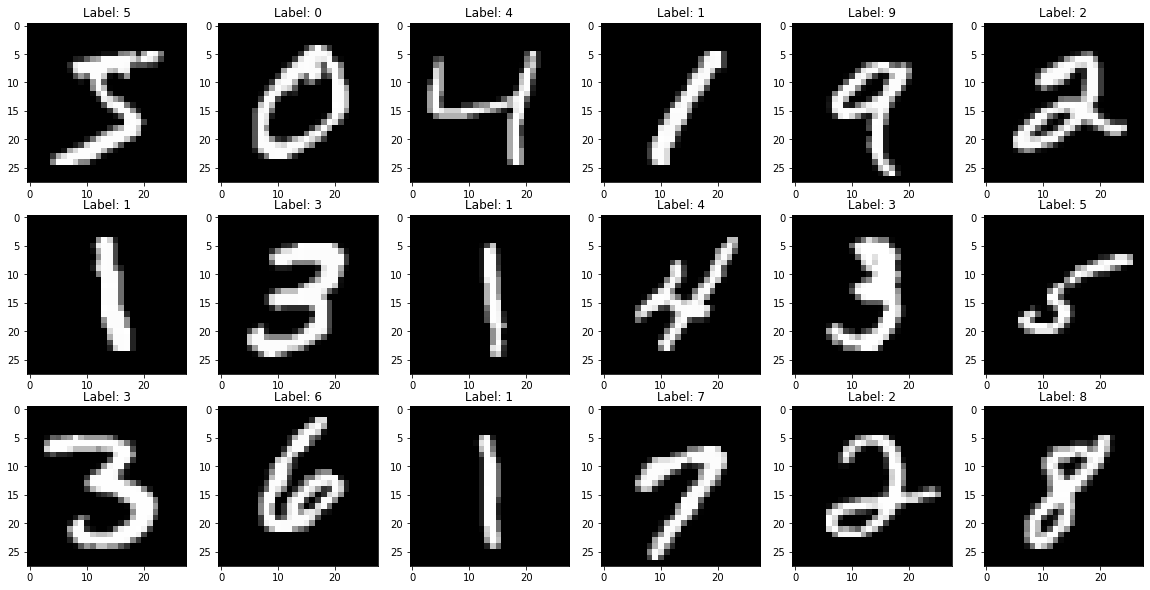

In [68]:
plot_mnist(data=mnist_tr)

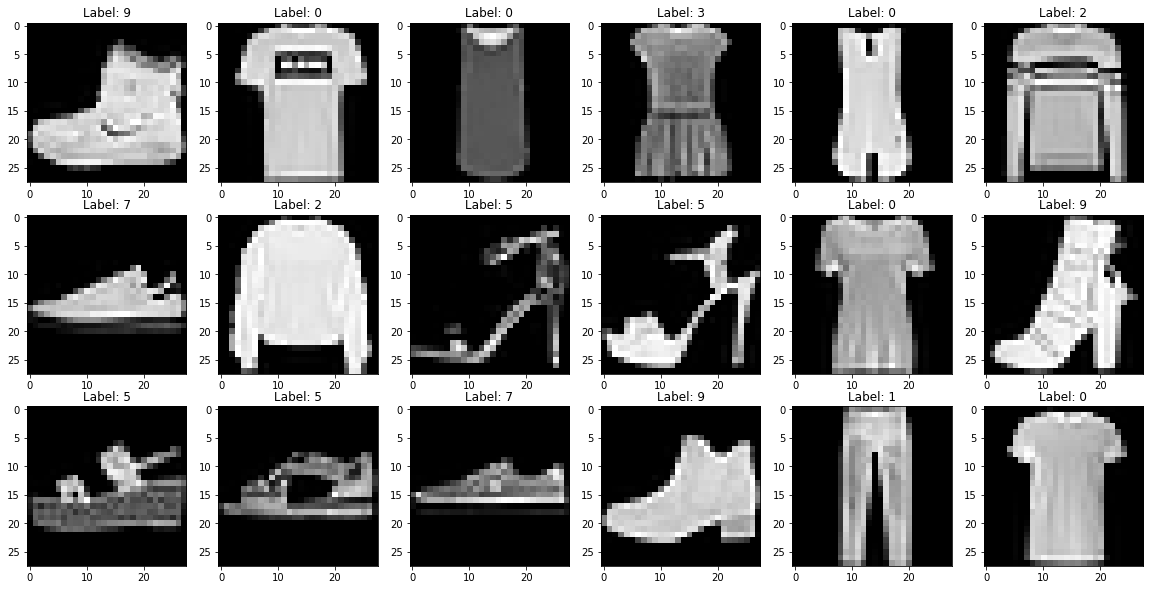

In [69]:
plot_mnist(data=fmnist_tr)

### Split train dataset into train and valid

In [70]:
class mnist_dataset(Dataset):
  def __init__(self, data, targets, transform=None, target_transform=None):
    super().__init__()

    self.data = data
    self.targets = targets
    self.transform = transform
    self.target_transform = target_transform
    pass

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    x, y = self.data[idx], self.targets[idx]

    if self.transform:
      x = self.transform(x)
    if self.target_transform:
      y = self.target_transform(y)

    return x, y

In [71]:
def split_train_valid(dataset, valid_ratio=0.1):
  # 이 부분을 채워 보겠습니다.
  # 실습 때 사용한 부분을 그대로 적용하셔도 되지만, 가능하다면 학습 데이터를 random하게 섞은 후에 split을 시도해보겠습니다.
  # 기존의 실습 코드는 데이터의 앞 부분을 train, 뒷 부분을 valid로 사용합니다.
  # 주의하세요, dataset의 data와 targets을 똑같이 shuffle 하셔야 원하는 label을 제대로 지정해 줄 수 있습니다!
  # 시도해 보시고 shuffle이 제대로 안 되는 것 같으면 5주차 실습에 있는 코드를 사용해 주세요.

  #n_valid = int(len(dataset) * valid_ratio)
  
  #train_data = dataset.data[:-n_valid].numpy()
  #valid_data = dataset.data[-n_valid:].numpy()
  #train_targets = dataset.targets[:-n_valid]
  #valid_targets = dataset.targets[-n_valid:]
  
  from sklearn.model_selection import train_test_split
  train_data, valid_data, train_targets, valid_targets = train_test_split(dataset.data,dataset.targets,test_size=0.9,shuffle=True,random_state=42)

  train_data = train_data.numpy()
  valid_data = valid_data.numpy()

  train = mnist_dataset(data=train_data, targets=train_targets, transform=dataset.transform, target_transform=dataset.target_transform)
  valid = mnist_dataset(data=valid_data, targets=valid_targets, transform=dataset.transform, target_transform=dataset.target_transform)

  return train, valid

In [72]:
mnist_train, mnist_valid = split_train_valid(dataset=mnist_tr)
fmnist_train, fmnist_valid = split_train_valid(dataset=fmnist_tr)

### Check shuffling result

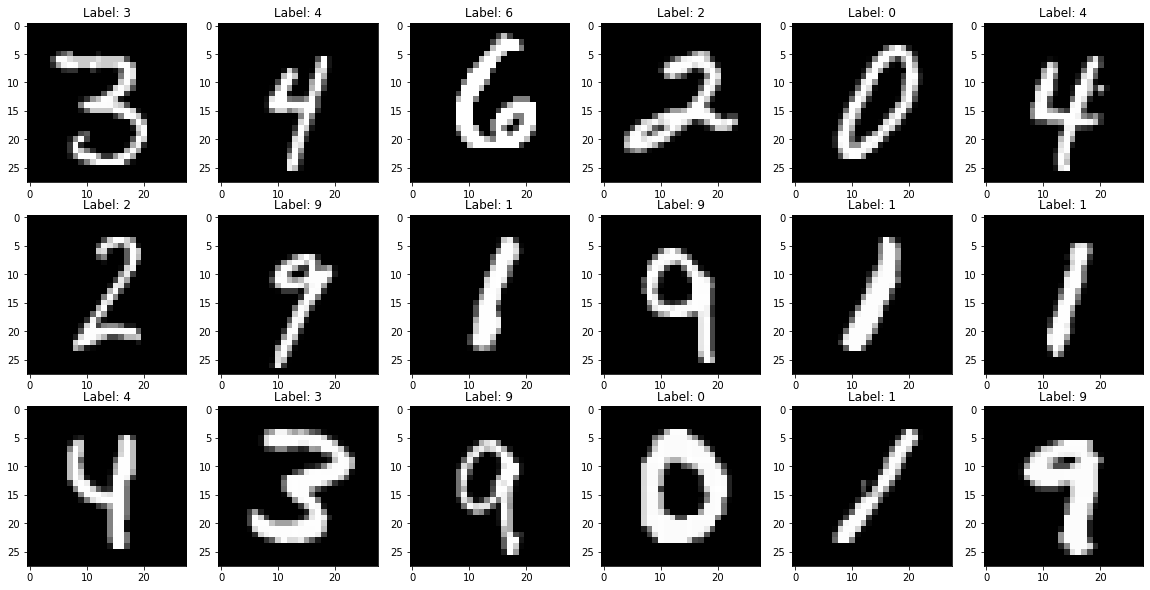

In [73]:
# 위에서 출력한 결과와 label이 그대로인지 확인해 보세요!
# Shuffle에 성공하셨다면 위와는 다른 그림들이 출력됩니다.
# 각 그림에 해당하는 label은 정확히 적용이 되는지 확인해보세요!
plot_mnist(data=mnist_train)

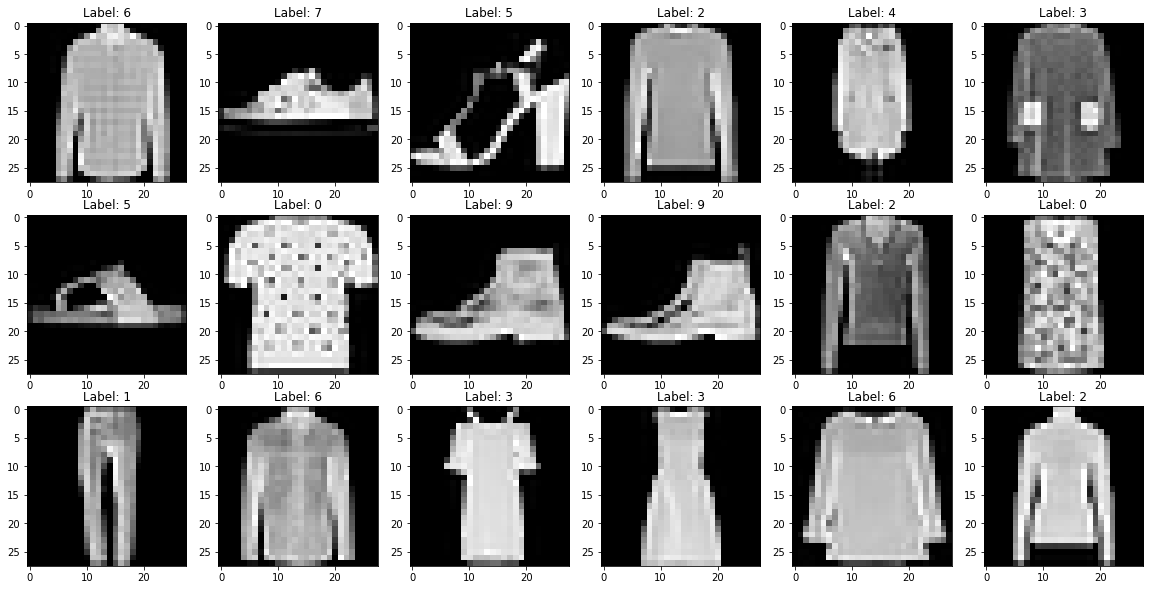

In [74]:
plot_mnist(data=fmnist_train)

### Get loaders

In [75]:
# 필요하다면, 후에 이 부분도 수정해 보세요!
# batch size를 바꾸시면 data loader를 다시 만들어야 합니다!
# MNIST는 거의 차이가 없을 것 같은데, FMNIST는 영향을 받을 수도 있습니다!
b_size = 256

In [76]:
mnist = [DataLoader(dataset=d, batch_size=b_size, shuffle=True, drop_last=True) for d in [mnist_train, mnist_valid, mnist_test]]
fmnist = [DataLoader(dataset=d, batch_size=b_size, shuffle=True, drop_last=True) for d in [fmnist_train, fmnist_valid, fmnist_test]]
datas = {"mnist": mnist, "fmnist": fmnist}

## 2. Model

### Base model

In [78]:
class BaseClassifier(nn.Module):
  def __init__(self, n_class=10):
    super().__init__()

    self.name = "base"
    self.model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28, 64),
        nn.ReLU(),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64, n_class),
    )

  def forward(self, x):
    return self.model(x)

### Customized models

In [79]:
class FirstClassifier(nn.Module):
  def __init__(self, n_class=10):
    super().__init__()

    self.name = "first"
    # Model을 만들어 봅시다.
    # 구조와 activation function, 그 외에 다른 기법들의 사용 유무와 사용 위치를 정할 수 있습니다.
    self.model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28, 256),
        nn.Dropout(p=0.5),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.Dropout(p=0.5),
        nn.ReLU(),
        nn.Linear(128, n_class),
    )

  def forward(self, x):
    return self.model(x)

# FirstClassifier 말고도 다양한 모델을 만들어서 학습을 시켜보고 성능을 비교해 볼 수 있습니다.

In [80]:
class SecondClassifier(nn.Module):
  def __init__(self, n_class=10):
    super().__init__()

    self.name = "second"
    # Model을 만들어 봅시다.
    # 구조와 activation function, 그 외에 다른 기법들의 사용 유무와 사용 위치를 정할 수 있습니다.
    self.model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Linear(128, n_class),
    )

  def forward(self, x):
    return self.model(x)

In [81]:
class ThirdClassifier(nn.Module):
  def __init__(self, n_class=10):
    super().__init__()

    self.name = "third"
    # Model을 만들어 봅시다.
    # 구조와 activation function, 그 외에 다른 기법들의 사용 유무와 사용 위치를 정할 수 있습니다.
    self.model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28, 256),
        nn.BatchNorm1d(256),
        nn.Dropout(p=0.5),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.BatchNorm1d(128),
        nn.Dropout(p=0.5),
        nn.ReLU(),
        nn.Linear(128, n_class),
    )

  def forward(self, x):
    return self.model(x)

### Using get_model function

In [82]:
def get_model(model_name):
  if model_name.lower() == "base":
    return BaseClassifier()
  elif model_name.lower() == "first":
    return FirstClassifier()
  elif model_name.lower() == "second":
    return SecondClassifier()
  elif model_name.lower() == "third":
    return ThirdClassifier()
  else:
    raise ValueError(f"model name {model_name} is not supported")

# get_model 함수가 activation function을 받고, 각 classifier를 정의할 때 activation function을 함께 넘겨주도록 만들 수도 있습니다!
# 그렇게 하면 훨씬 적은 수의 model class로 더 다양한 경우를 사용할 수 있을 것 같네요.
# 여러분이 원하는 기능을 가지도록 다양한 model class와 get_model 함수들을 코딩해 보세요!

## 3. Trainer

### Make trainer

In [101]:
class Trainer(nn.Module):
  def __init__(self, model, opt="sgd", lr=0.001, has_scheduler=False, device="cpu"):
    super().__init__()
    self.path = f"_model_{model.name}_opt_{opt}_lr_{lr}"

    self.model = model
    self.loss = nn.CrossEntropyLoss()
    self._get_optimizer(opt=opt.lower(), lr=lr)
    self.has_scheduler = has_scheduler
    if self.has_scheduler:
      self._get_scheduler()

    self.device = device
    pass

  def _get_optimizer(self, opt, lr=0.001):
    # 몇 가지 optimizer를 더 찾아서 적용해 볼까요?
    if opt == "sgd":
      self.optimizer = torch.optim.SGD(params=self.model.parameters(), lr=lr)
    elif opt == "adam":
      self.optimizer = torch.optim.Adam(params=self.model.parameters(), lr=lr)
    elif opt == "rmsprop":
      self.optimizer = torch.optim.RMSprop(params=self.model.parameters(), lr=lr)
    else:
      raise ValueError(f"optimizer {opt} is not supproted")

  def _get_scheduler(self):
    self.scheduler = torch.optim.lr_scheduler.StepLR(optimizer=self.optimizer, step_size=5, gamma=0.5, verbose=True)

  def train(self, data_name, train_loader, valid_loader, max_epochs=10):
    print("===== Train Start =====")
    history = {"train_loss": [], "train_acc": [], "valid_loss": [], "valid_acc": []}
    for e in range(max_epochs):
      train_loss, train_acc = self._train_epoch(train_loader)
      valid_loss, valid_acc = self._valid_epoch(valid_loader)

      history["train_loss"].append(train_loss)
      history["train_acc"].append(train_acc)
      history["valid_loss"].append(valid_loss)
      history["valid_acc"].append(valid_acc)

      if self.has_scheduler:
        self.scheduler.step()

      if e % 10 == 0:
        print(f"Epoch: {e}, train loss: {train_loss:>6f}, train acc: {train_acc:>3f}, valid loss: {valid_loss:>6f}, valid acc: {valid_acc:>3f}")

    self.plot_history(history, data_name, max_epochs)

  def _train_epoch(self, train_loader):
    epoch_loss, epoch_acc = 0, 0
    self.model.train()
    for (x, y) in train_loader:
      x = x.to(self.device)
      y = y.to(self.device)

      y_hat = self.model(x)
      loss = self.loss(y_hat, y)

      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

      epoch_loss += loss.to("cpu").item()
      epoch_acc += (y_hat.argmax(1) == y).type(torch.float).to("cpu").mean().item()

    return epoch_loss / len(train_loader), epoch_acc / len(train_loader)
  
  def _valid_epoch(self, valid_loader):
    epoch_loss, epoch_acc = 0, 0
    self.model.eval()
    with torch.no_grad():
      for (x, y) in valid_loader:
        x = x.to(self.device)
        y = y.to(self.device)

        y_hat = self.model(x)
        loss = self.loss(y_hat, y)

        epoch_loss += loss.to("cpu").item()
        epoch_acc += (y_hat.argmax(1) == y).type(torch.float).to("cpu").mean().item()

    return epoch_loss / len(valid_loader), epoch_acc / len(valid_loader)

  def plot_history(self, history, data_name, max_epochs):
    fig = plt.figure(figsize=(10, 5))

    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history["train_loss"], color="red", label="train loss")
    ax.plot(history["valid_loss"], color="blue", label="valid loss")
    ax.set_title("Loss")
    ax.legend()

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history["train_acc"], color="red", label="train acc")
    ax.plot(history["valid_acc"], color="blue", label="valid acc")
    ax.set_title("Acc")
    ax.legend()

    path = os.path.join(os.getcwd(), "drive", "MyDrive", "Colab Notebooks", "plots", f"data_{data_name}" + self.path + f"_max_epochs_{max_epochs}.png")
    plt.savefig(path, bbox_inches="tight")
    pass

  def test(self, test_loader):
    print("===== Test Start =====")
    epoch_loss, epoch_acc = 0, 0
    self.model.eval()
    with torch.no_grad():
      for (x, y) in test_loader:
        x = x.to(self.device)
        y = y.to(self.device)

        y_hat = self.model(x)
        loss = self.loss(y_hat, y)

        epoch_loss += loss.to("cpu").item()
        epoch_acc += (y_hat.argmax(1) == y).type(torch.float).to("cpu").mean().item()

    epoch_loss /= len(test_loader)
    epoch_acc /= len(test_loader)

    print(f"Test loss: {epoch_loss:>6f}, Test acc: {epoch_acc:>3f}")

### Train and test

In [102]:
# 해당 코드는 1번만 실행해 주시면 됩니다.
p = os.path.join(os.getcwd(), "drive", "MyDrive", "Colab Notebooks", "plots")
if not os.path.isdir(p):
  os.mkdir(p)

In [108]:
ds = ["mnist", "fmnist"]
models = ["base","first","second","third"]
opts = ["sgd","adam","rmsprop"]
lrs = [0.001,1e-6,5e-6]
max_epochs = 30

Adjusting learning rate of group 0 to 1.0000e-03.
===== Data: mnist, Model: base, Optimizer: sgd, lr: 0.001, max_epochs: 30 =====
===== Train Start =====
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 0, train loss: 2.304239, train acc: 0.126019, valid loss: 2.303415, valid acc: 0.126376
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 5.0000e-04.
Adjusting learning rate of group 0 to 5.0000e-04.
Adjusting learning rate of group 0 to 5.0000e-04.
Adjusting learning rate of group 0 to 5.0000e-04.
Adjusting learning rate of group 0 to 5.0000e-04.
Adjusting learning rate of group 0 to 2.5000e-04.
Adjusting learning rate of group 0 to 2.5000e-04.
Epoch: 10, train loss: 2.299648, train acc: 0.147928, valid loss: 2.299189, valid acc: 0.148400
Adjusting learning rate of group 0 to 2.5000e-04.
Adjusting learning rate of group 0 to 2.5000e-04.
Adjus

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:86: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


===== Test Start =====
Test loss: 2.388103, Test acc: 0.103265
Adjusting learning rate of group 0 to 1.0000e-03.
===== Data: mnist, Model: second, Optimizer: adam, lr: 0.001, max_epochs: 30 =====
===== Train Start =====
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 0, train loss: 0.946438, train acc: 0.798404, valid loss: 0.911027, valid acc: 0.889007
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 5.0000e-04.
Adjusting learning rate of group 0 to 5.0000e-04.
Adjusting learning rate of group 0 to 5.0000e-04.
Adjusting learning rate of group 0 to 5.0000e-04.
Adjusting learning rate of group 0 to 5.0000e-04.
Adjusting learning rate of group 0 to 2.5000e-04.
Adjusting learning rate of group 0 to 2.5000e-04.
Epoch: 10, train loss: 0.018411, train acc: 1.000000, valid loss: 0.161634, valid acc: 0.951507
Adjusting learning rate of group 0 to 2

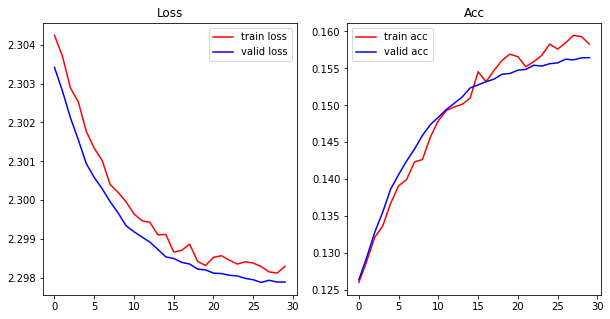

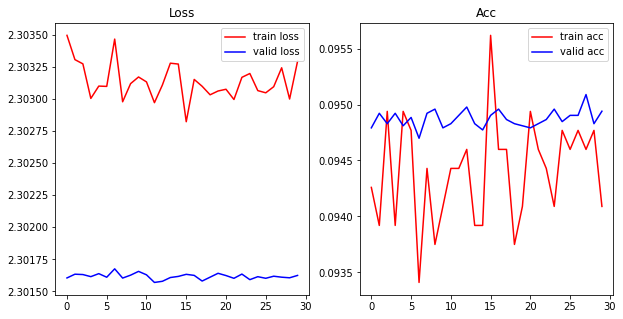

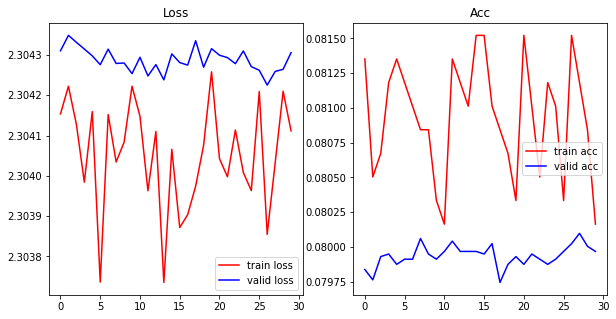

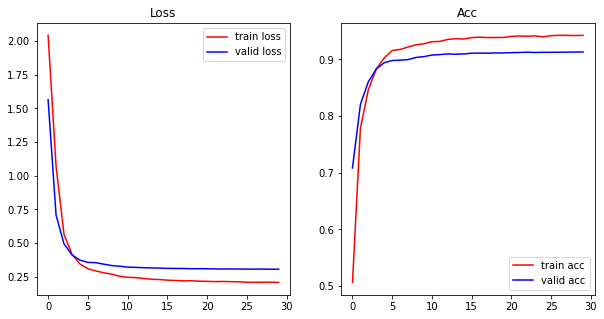

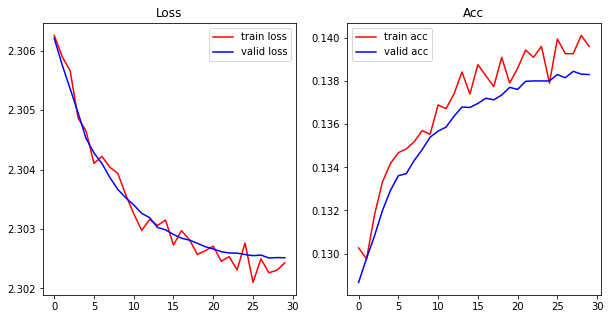

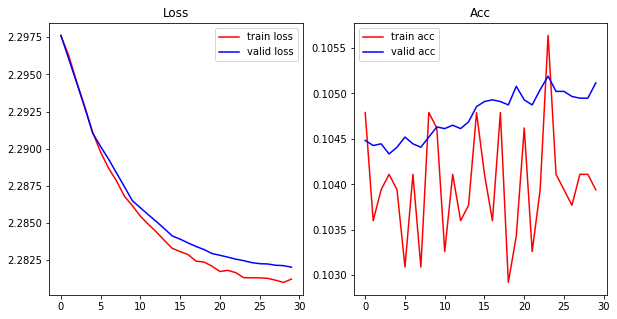

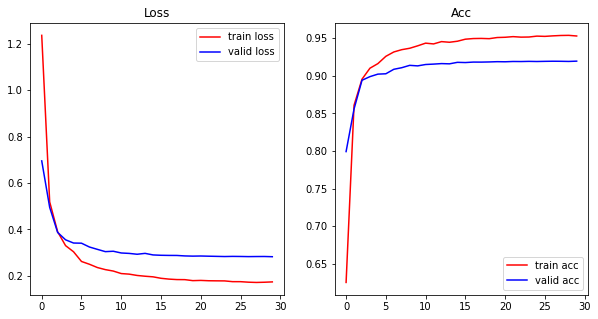

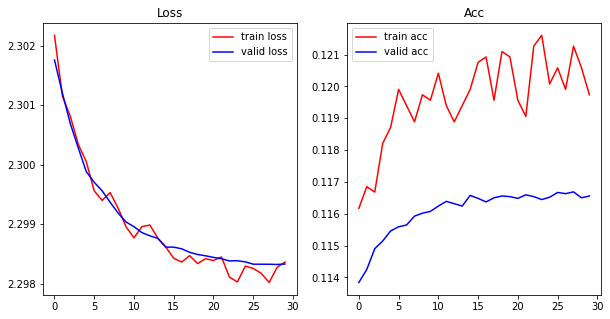

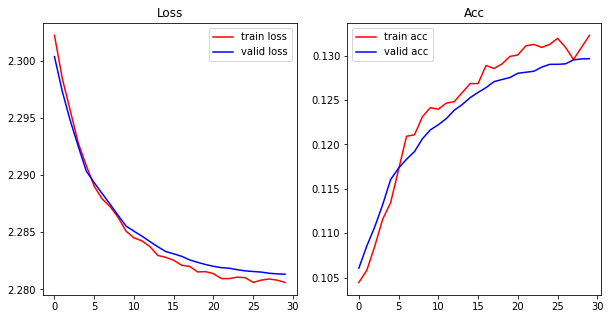

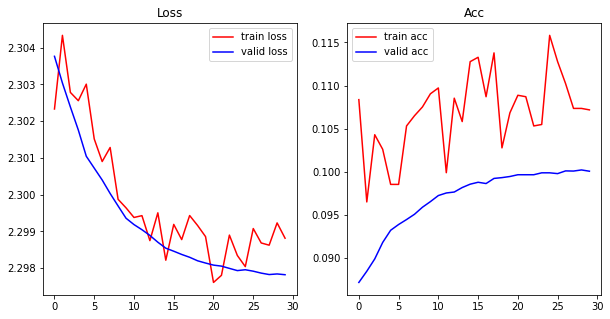

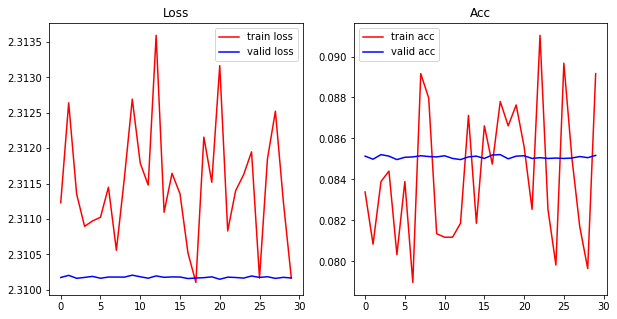

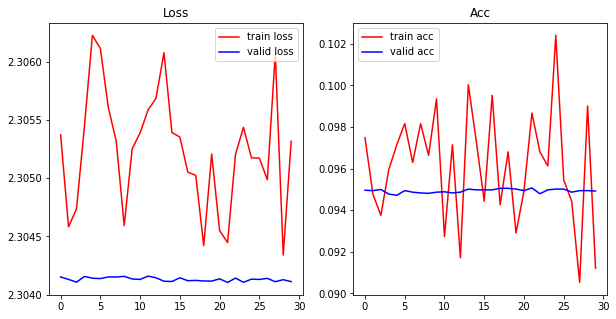

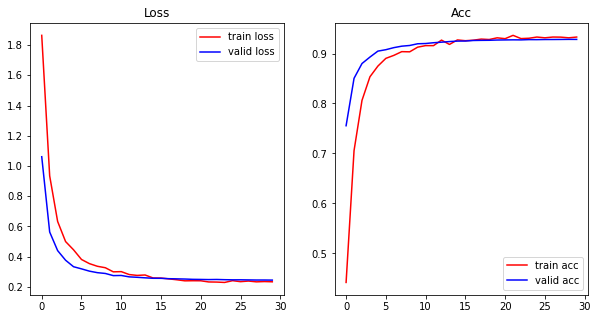

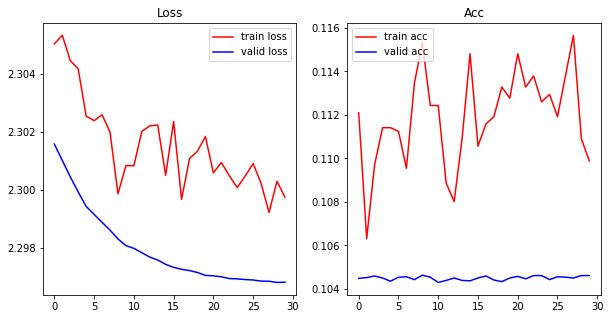

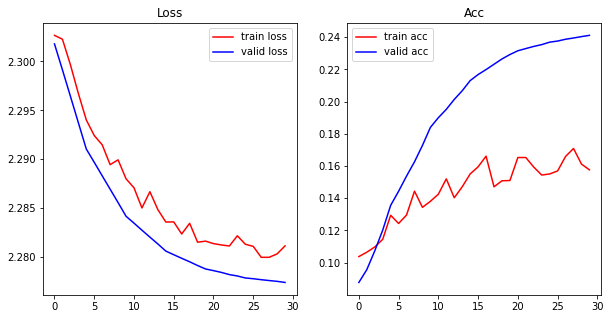

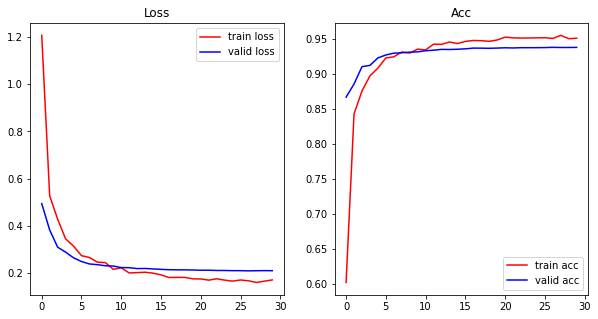

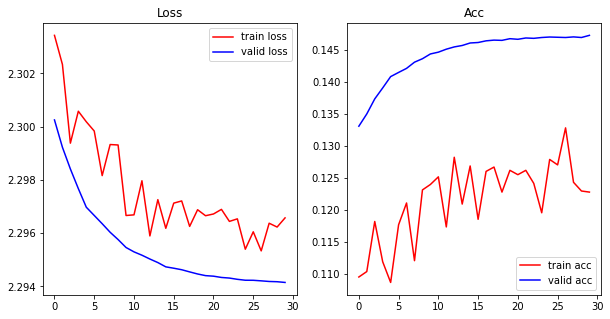

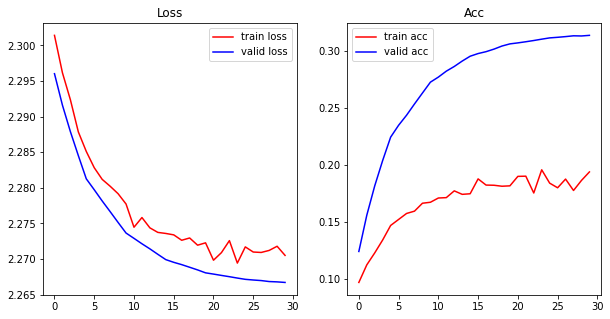

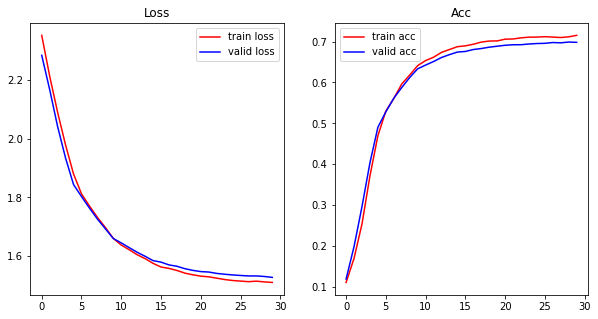

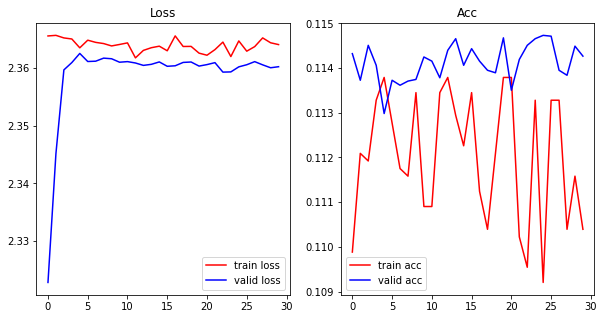

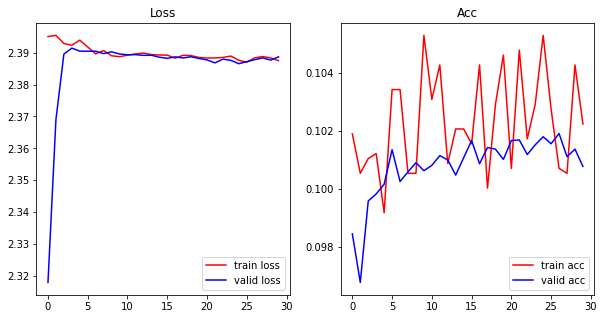

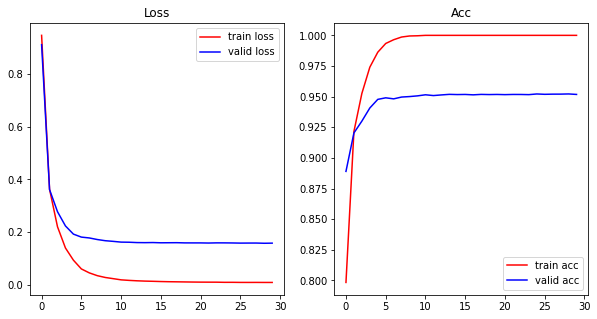

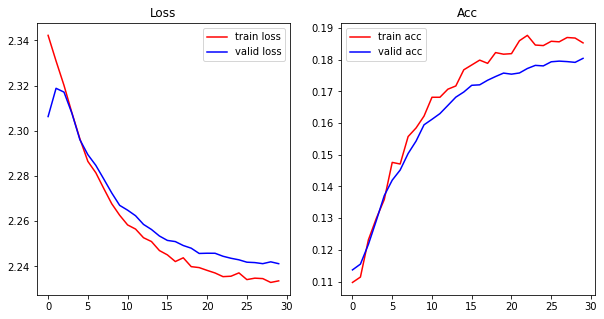

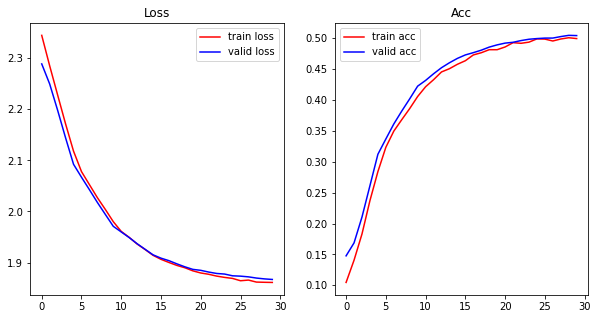

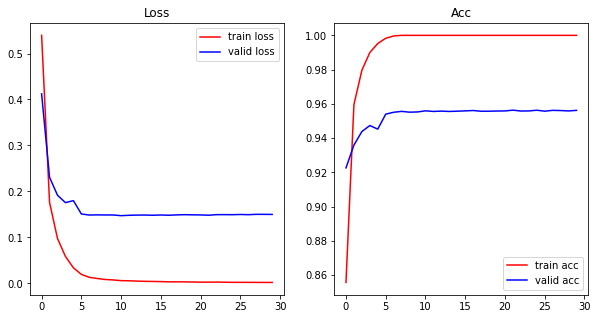

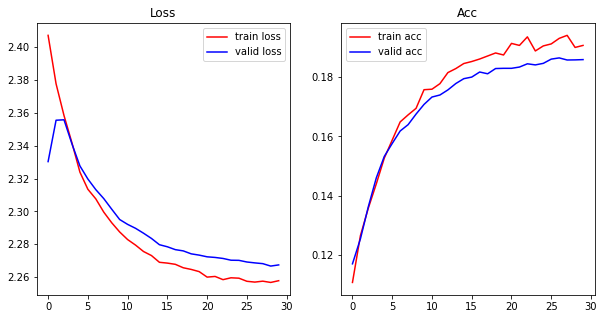

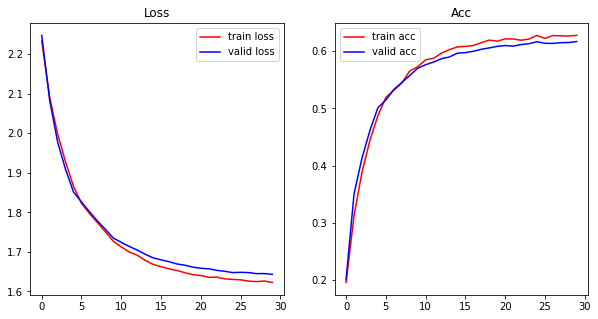

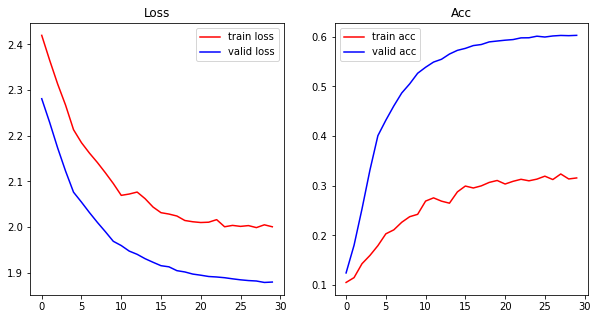

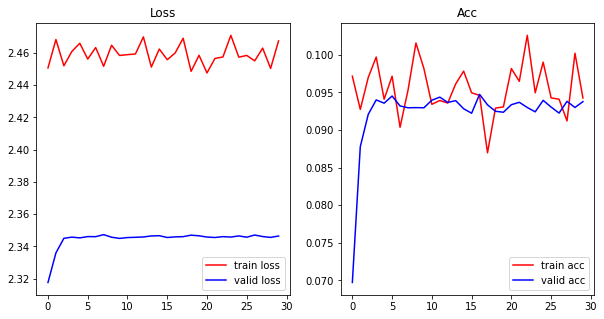

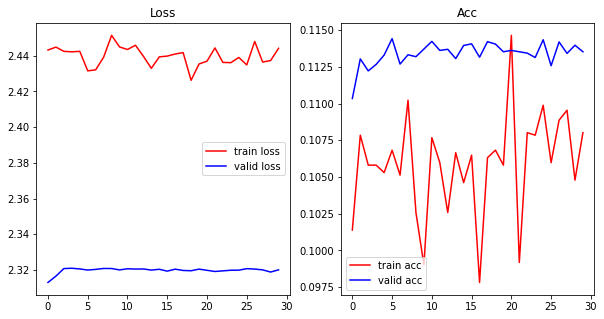

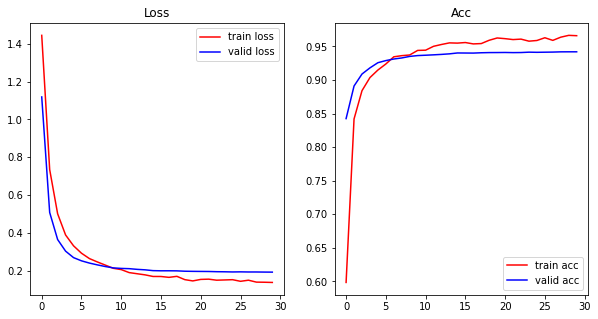

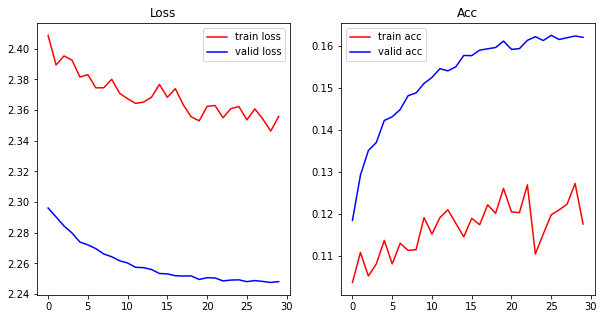

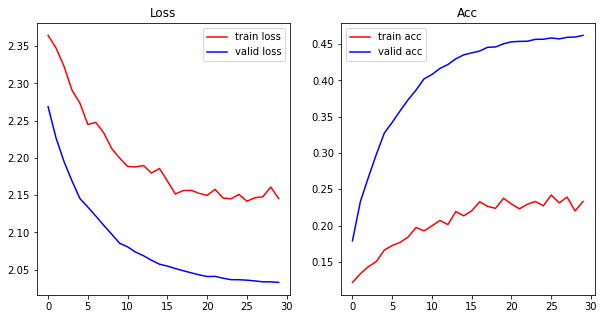

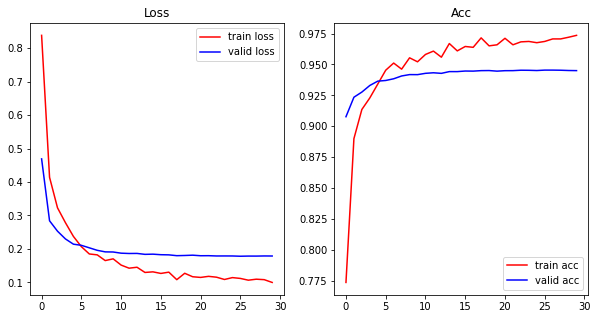

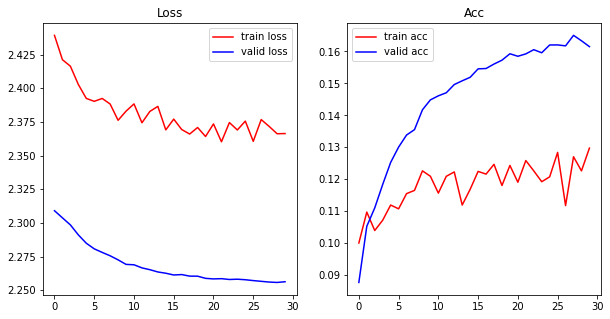

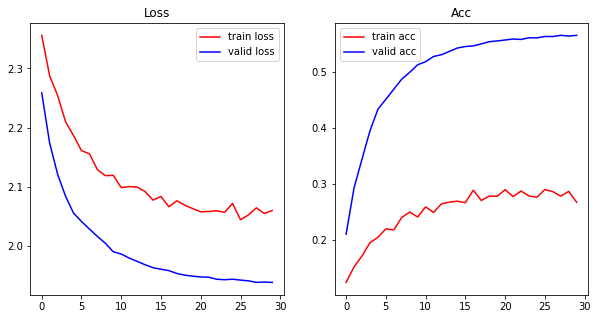

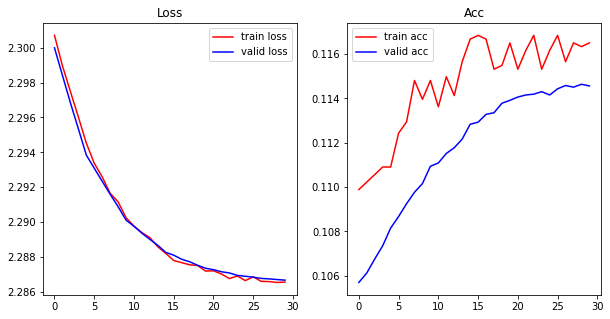

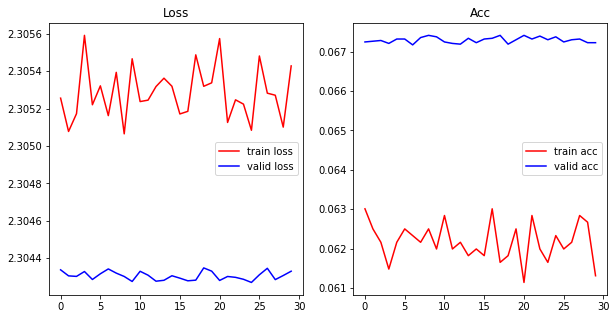

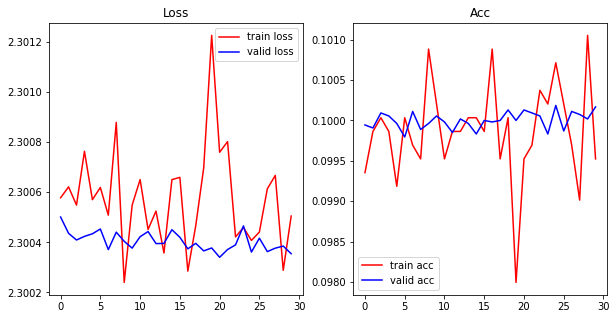

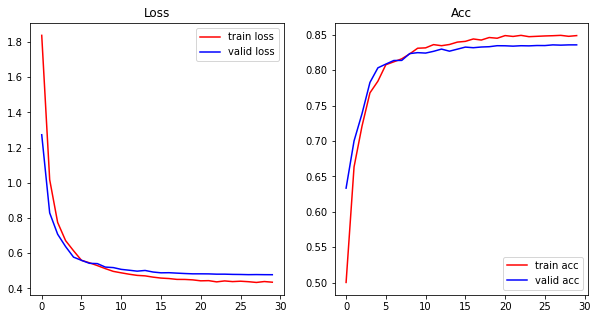

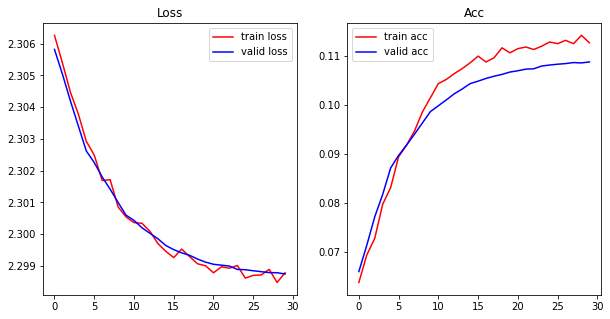

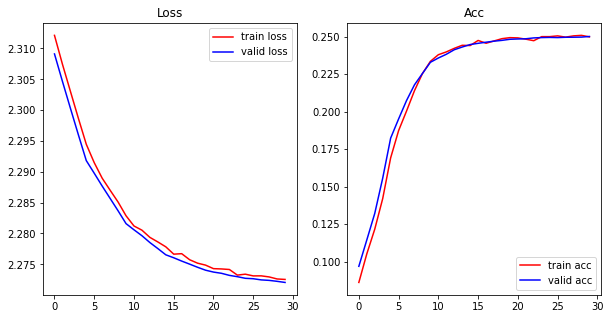

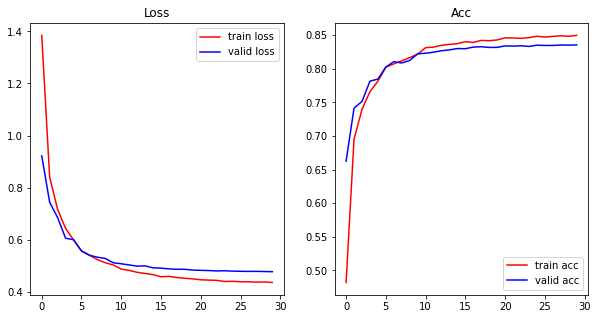

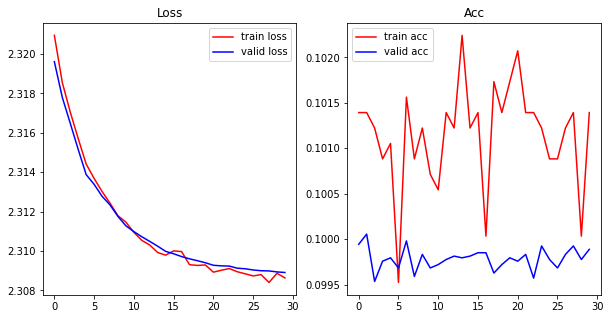

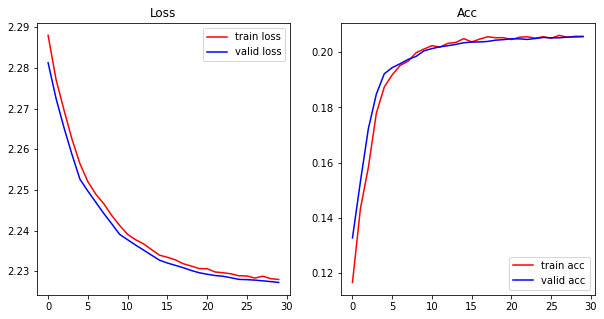

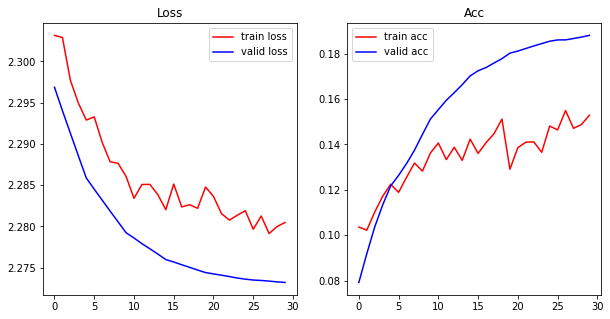

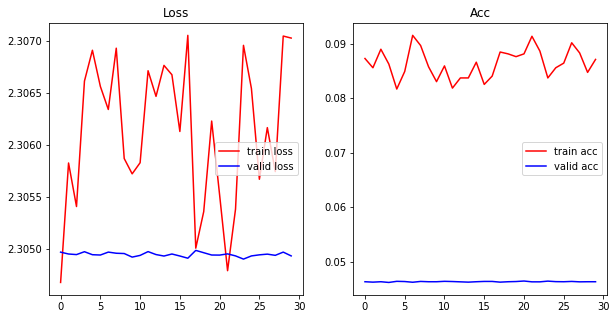

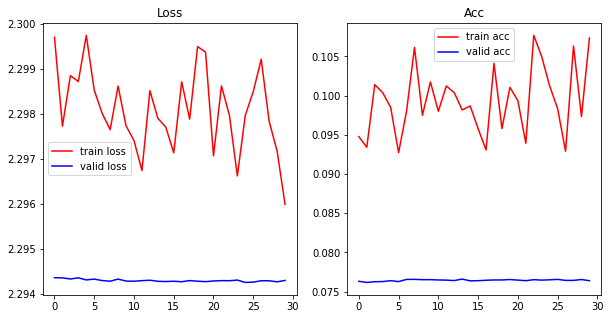

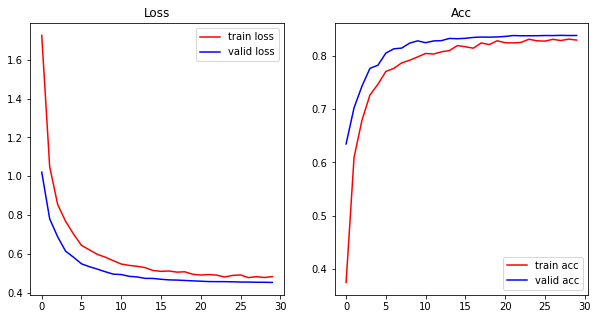

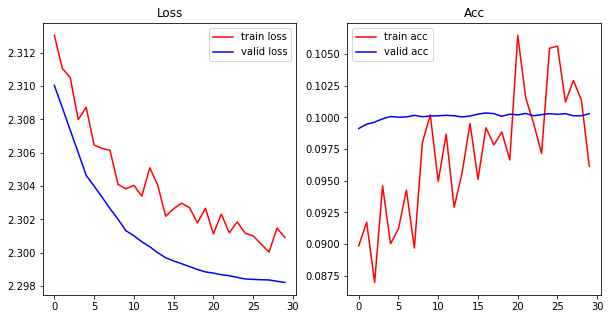

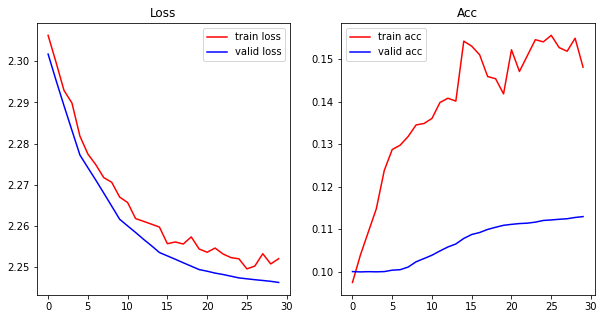

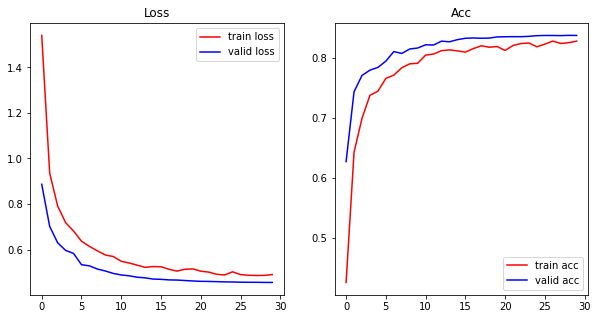

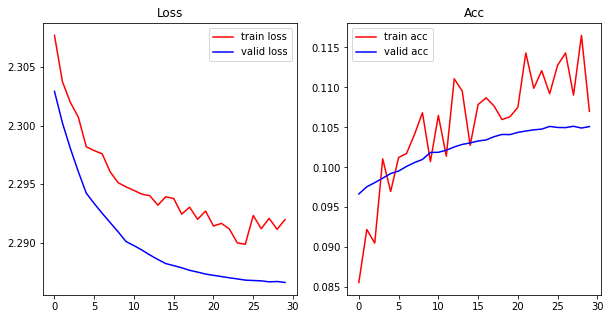

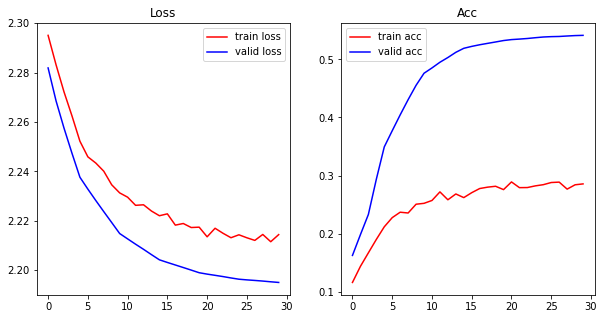

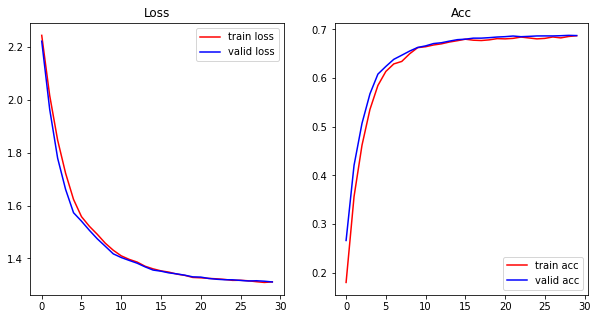

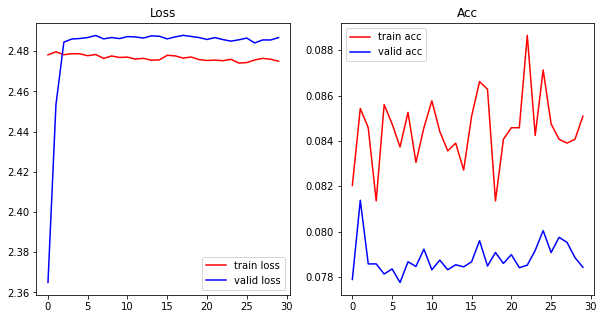

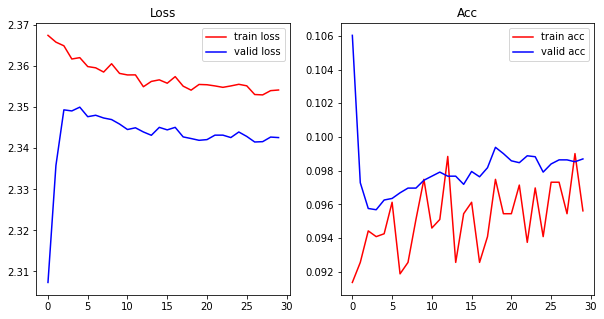

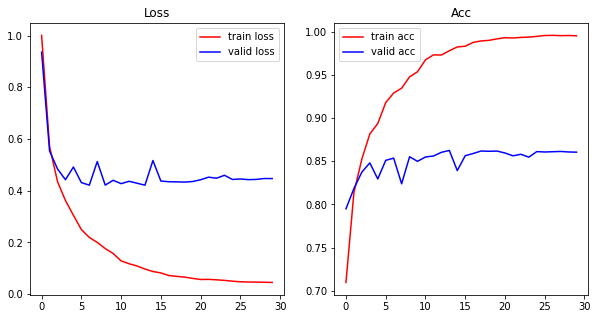

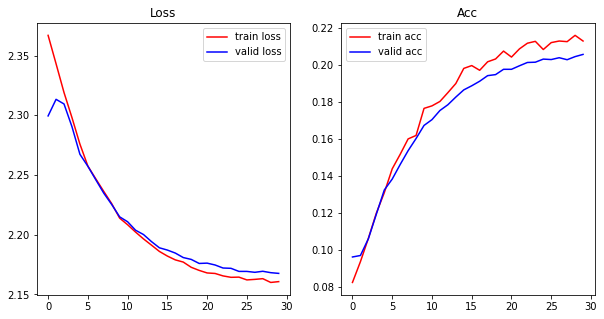

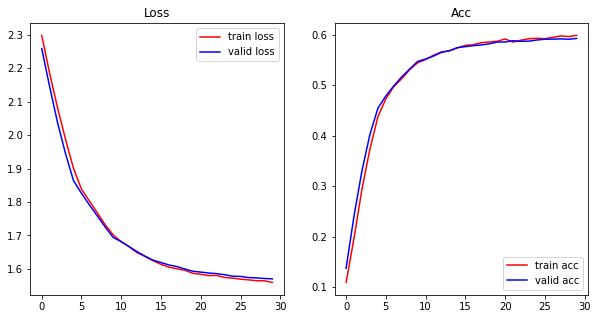

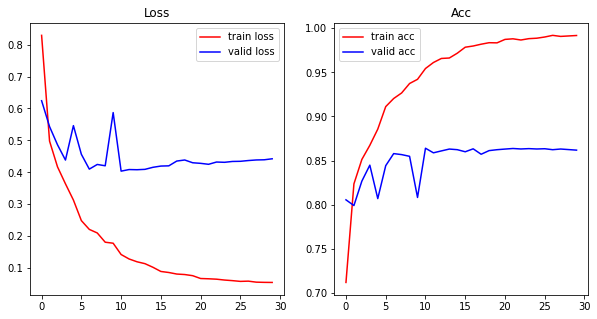

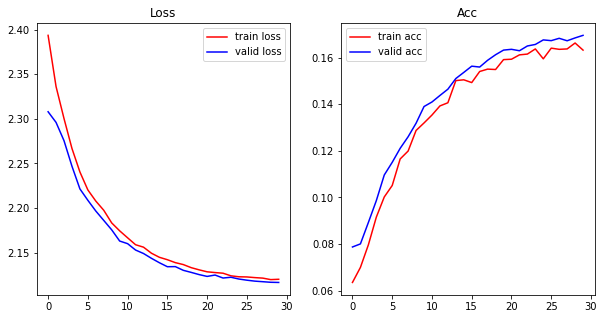

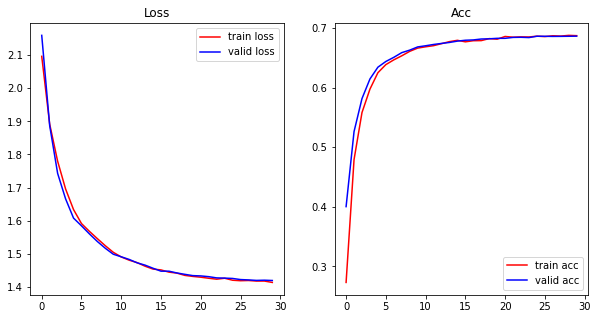

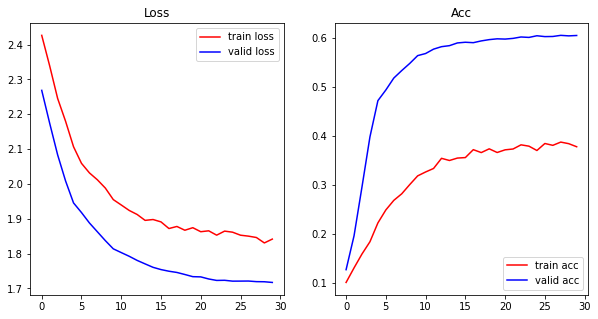

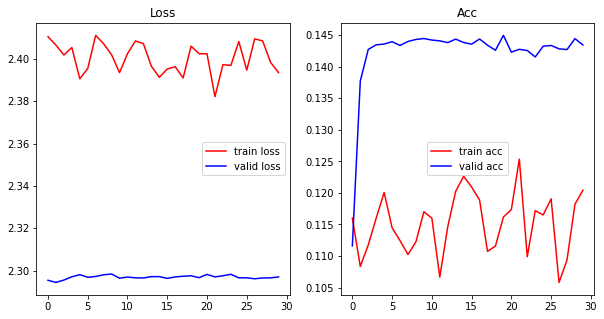

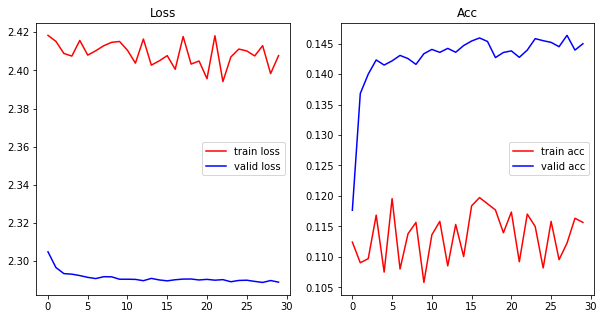

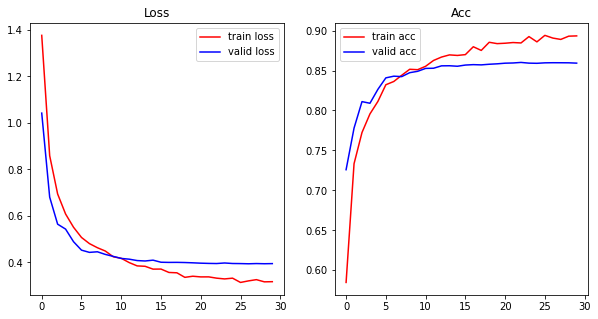

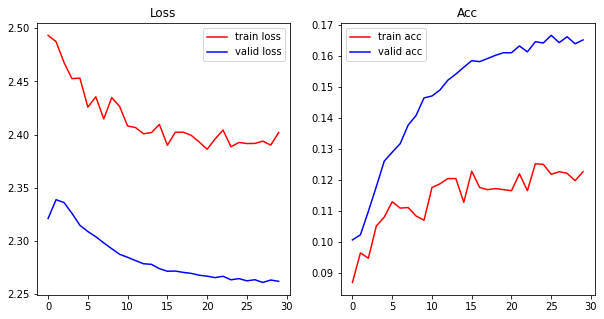

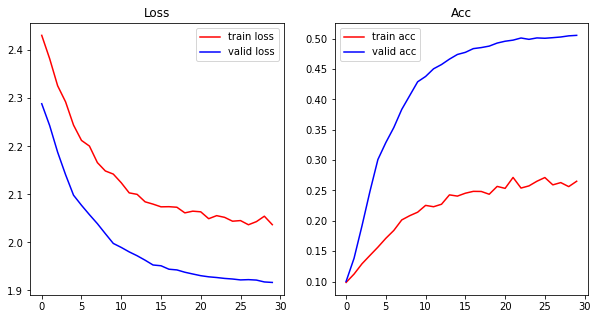

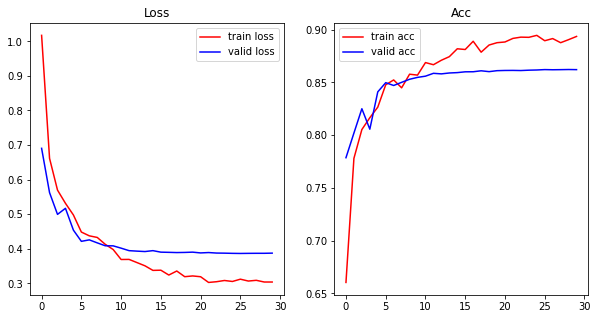

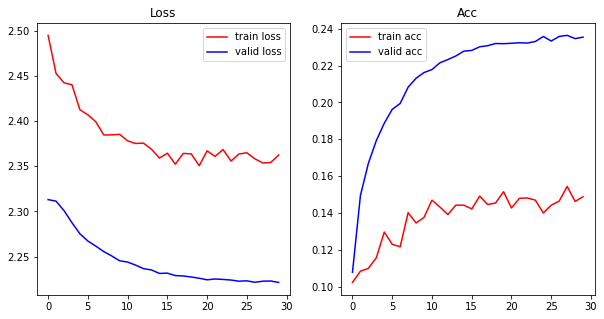

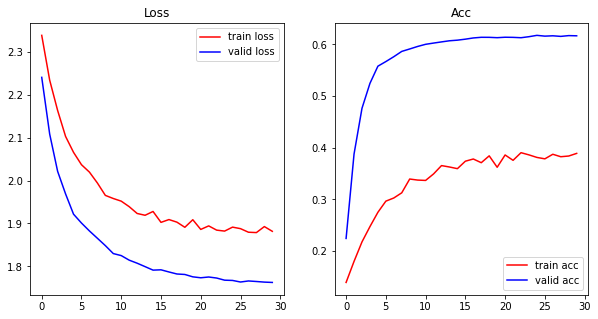

In [109]:
for d in ds:
  for m in models:
    for opt in opts:
      for lr in lrs:
        model = get_model(model_name = m)
        trainer = Trainer(model=model, opt=opt, lr=lr, has_scheduler=True)
        print(f"===== Data: {d}, Model: {m}, Optimizer: {opt}, lr: {lr}, max_epochs: {max_epochs} =====")
        trainer.train(data_name=d, train_loader=datas[d][0], valid_loader=datas[d][1], max_epochs=max_epochs)
        trainer.test(test_loader=datas[d][2])

In [ ]:
# MNIST dataset에 대해 여러분이 찾은 최적의 조건으로 학습을 한 번 더 진행해 주세요.
d = "mnist"
m = "third"
opt = "rmsprop"
lr = 0.001
max_epochs = 500

model = get_model(model_name = m)
trainer = Trainer(model=model, opt=opt, lr=lr, has_scheduler=True)
print(f"===== Data: {d}, Model: {m}, Optimizer: {opt}, lr: {lr}, max_epochs: {max_epochs} =====")
trainer.train(data_name=d, train_loader=datas[d][0], valid_loader=datas[d][1], max_epochs=max_epochs)
trainer.test(test_loader=datas[d][2])

Adjusting learning rate of group 0 to 1.0000e-03.
===== Data: mnist, Model: third, Optimizer: rmsprop, lr: 0.001, max_epochs: 500 =====
===== Train Start =====
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 0, train loss: 0.825274, train acc: 0.777174, valid loss: 0.450094, valid acc: 0.901711
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 5.0000e-04.
Adjusting learning rate of group 0 to 5.0000e-04.
Adjusting learning rate of group 0 to 5.0000e-04.
Adjusting learning rate of group 0 to 5.0000e-04.
Adjusting learning rate of group 0 to 5.0000e-04.
Adjusting learning rate of group 0 to 2.5000e-04.
Adjusting learning rate of group 0 to 2.5000e-04.
Epoch: 10, train loss: 0.153460, train acc: 0.955163, valid loss: 0.191157, valid acc: 0.941332
Adjusting learning rate of group 0 to 2.5000e-04.
Adjusting learning rate of group 0 to 2.5000e-04.

===== Data: fmnist, Model: base, Optimizer: sgd, lr: 0.0, max_epochs: 10 =====
===== Train Start =====
Epoch: 0, train loss: 2.299460, train acc: 0.096856, valid loss: 2.300806, valid acc: 0.096807
===== Test Start =====
Test loss: 2.299201, Test acc: 0.097656


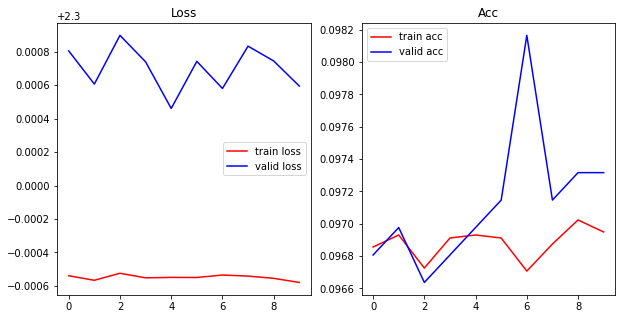

In [25]:
# FashionMNIST dataset에 대해 여러분이 찾은 최적의 조건으로 학습을 한 번 더 진행해 주세요.
d = "fmnist"
m = "second"
opt = "rmsprop"
lr = 0.001
max_epochs = 500

model = get_model(model_name = m)
trainer = Trainer(model=model, opt=opt, lr=lr, has_scheduler=True)
print(f"===== Data: {d}, Model: {m}, Optimizer: {opt}, lr: {lr}, max_epochs: {max_epochs} =====")
trainer.train(data_name=d, train_loader=datas[d][0], valid_loader=datas[d][1], max_epochs=max_epochs)
trainer.test(test_loader=datas[d][2])